In [46]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.version

'3.6.0 (v3.6.0:41df79263a11, Dec 22 2016, 17:23:13) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

We first model the mean of kpi value over time. This is because adding the ramp-up period might make the experiment too long, which leads to the shift of the kpi mean (e.g. run into a sale season). We simulate this behaviour by a sharp logistic function from 0.2 to 0.8, the change is centered at day 10.

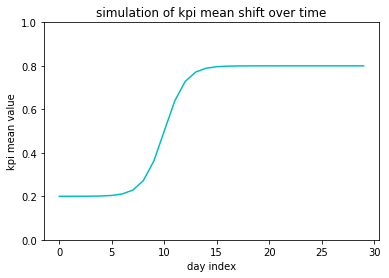

In [47]:
x = np.arange(30)
y = 0.6 / (1 + np.exp(-x+10)) + 0.2
plt.plot(x, y, 'c-')
plt.ylim([0, 1])
plt.xlabel("day index")
plt.ylabel("kpi mean value")
plt.title("simulation of kpi mean shift over time")
plt.show()

Another propery we want to model is the effect of exposure. If a user is exposed to treatment for a long period, we might get a decayed kpi value from this user because he/she is used to the behaviour. Vice versa for the control group. We model this effect by a flipped logistic function, but with a smoother change. Again, we assume the changing point of exposure effect is centered at day 10. 

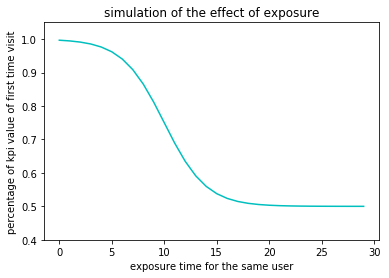

In [48]:
x = np.arange(30)
k = 0.5
y = 0.5 / (1 + np.exp(-k*(10-x))) + 0.5
            
plt.plot(x, y, 'c-')
plt.ylim([0.4, 1.05])
plt.xlabel("exposure time for the same user")
plt.ylabel("percentage of kpi value of first time visit")
plt.title("simulation of the effect of exposure")
plt.show()

Now let's model some ramp-ups. :)
We use the option that we only send a part of the traffic to a/b testing during ramp-up, traffic that does not go to a/b testing will be by default the control. After reaching a/b testing, we always make a 50%/50% split of treatment and control.
We simulate in a way that ramp-up happens on day 0 (10% ), day 5 (30%), and day 10 (50%). This is illustrated in the following table.

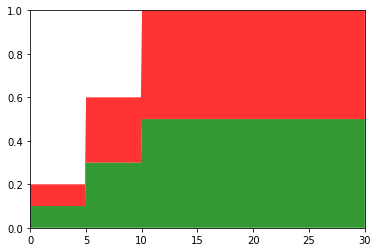

In [50]:
x = np.linspace(0, 30, 300)

y0 = 0
y1 = [0.1 if i<5 else
      0.3 if i<10 else
      0.5 for i in x]
y2 = [0.2 if i<5 else
      0.6 if i<10 else
      1.0 for i in x]

fig, ax = plt.subplots()
ax.fill_between(x, y0, y1, facecolor='green', interpolate=True, alpha=0.8)
ax.fill_between(x, y1, y2, facecolor='red', interpolate=True, alpha=0.8)
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)

plt.show()